# Marketing Spending Analysis
# Project Overview
This project analyzes marketing spending to evaluate the effectiveness of various marketing campaigns and identify actionable insights for improving business outcomes.

# Objectives
Analyze overall ROMI and ROMI by campaigns.
Assess performance metrics based on spending, revenue, and conversion rates.
Conduct clustering analysis to segment campaigns and understand patterns in campaign performance, allowing for targeted marketing strategies and improved resource allocation.

Note:
To view the interactive Plotly graphs, please run the code cells that generate them. This is standard behavior for Plotly visualizations in Jupyter notebooks.


In [1]:
import pandas as pd
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Data Description
The dataset includes the following information:

* Date: Date of marketing budget spending.
* Campaign Name: Description of the campaign.
* Category: Type of marketing source (e.g., influencer, social).
* Campaign ID: Unique identifier for the campaign.
* Impressions: Number of times the ad was shown.
* Budget: Money spent on the campaign.
* Clicks: Number of clicks on the ad.
* Leads: Number of people who signed up.
* Orders: Number of completed purchases.
* Revenue: Total revenue earned.

In [2]:
df = pd.read_csv("/kaggle/input/analyze-the-marketing-spending/Marketing.csv")
df.head()  

,id,c_date,campaign_name,category,campaign_id,impressions,mark_spent,clicks,leads,orders,revenue
0,1,2021-02-01,facebook_tier1,social,349043,148263,7307.37,1210,13,1,4981.0
1,2,2021-02-01,facebOOK_tier2,social,348934,220688,16300.20,1640,48,3,14962.0
2,3,2021-02-01,google_hot,search,89459845,22850,5221.60,457,9,1,7981.0
3,4,2021-02-01,google_wide,search,127823,147038,6037.00,1196,24,1,2114.0
4,5,2021-02-01,youtube_blogger,influencer,10934,225800,29962.20,2258,49,10,84490.0


In [3]:
conn = sqlite3.connect("marketing.db")  
cursor = conn.cursor() 

In [4]:
df.to_sql("marketing_data", conn, if_exists="replace", index=False)


308

# Best Campaigns analysis
Used SQL to identify the top ten campaigns based on performance metrics.

In [5]:
query = "SELECT * FROM marketing_data LIMIT 5"
df_sql = pd.read_sql(query, conn)
df_sql

,id,c_date,campaign_name,category,campaign_id,impressions,mark_spent,clicks,leads,orders,revenue
0,1,2021-02-01,facebook_tier1,social,349043,148263,7307.37,1210,13,1,4981.0
1,2,2021-02-01,facebOOK_tier2,social,348934,220688,16300.20,1640,48,3,14962.0
2,3,2021-02-01,google_hot,search,89459845,22850,5221.60,457,9,1,7981.0
3,4,2021-02-01,google_wide,search,127823,147038,6037.00,1196,24,1,2114.0
4,5,2021-02-01,youtube_blogger,influencer,10934,225800,29962.20,2258,49,10,84490.0


In [6]:
query = """
WITH RankedCampaigns AS (
    SELECT
        c_date,
        campaign_name,
        category,
        SUM(mark_spent) AS total_spent,
        SUM(revenue) AS total_revenue,

        -- ✅ ROMI (Return on Marketing Investment)
        COALESCE(NULLIF(SUM(mark_spent), 0), 1) AS adjusted_mark_spent,
        COALESCE(NULLIF(SUM(revenue), 0), 1) AS adjusted_revenue,

        (COALESCE(NULLIF(SUM(revenue), 0), 1) - COALESCE(NULLIF(SUM(mark_spent), 0), 1)) 
        / COALESCE(NULLIF(SUM(mark_spent), 0), 1) AS ROMI,

        -- ✅ Click-Through Rate (CTR)
        COALESCE(NULLIF(SUM(impressions), 0), 1) AS adjusted_impressions,
        COALESCE(NULLIF(SUM(clicks), 0), 1) AS adjusted_clicks,

        COALESCE(SUM(clicks) * 1.0 / NULLIF(SUM(impressions), 0), 0) AS CTR,   
        
        -- ✅ Conversion Rates (CR1 and CR2)
        COALESCE(SUM(leads) * 1.0 / NULLIF(SUM(clicks), 0), 0) AS CR1,
        COALESCE(SUM(orders) * 1.0 / NULLIF(SUM(leads), 0), 0) AS CR2,

        -- ✅ Average Order Value (AOV)
        COALESCE(SUM(revenue) * 1.0 / NULLIF(SUM(orders), 0), 0) AS AOV,

        -- ✅ Cost Per Click (CPC)
        COALESCE(SUM(mark_spent) * 1.0 / NULLIF(SUM(clicks), 0), 0) AS CPC,

        -- ✅ Cost Per Lead (CPL)
        COALESCE(SUM(mark_spent) * 1.0 / NULLIF(SUM(leads), 0), 0) AS CPL,

        -- ✅ Customer Acquisition Cost (CAC)
        COALESCE(SUM(mark_spent) * 1.0 / NULLIF(SUM(orders), 0), 0) AS CAC

    FROM marketing_data
    GROUP BY campaign_name, category, c_date
)
SELECT * FROM RankedCampaigns ORDER BY c_date ASC;


"""
df_results = pd.read_sql_query(query, conn)
print(df_results)


         c_date         campaign_name    category  total_spent  total_revenue  \
0    2021-02-01        banner_partner       media       931.99            0.0   
1    2021-02-01        facebOOK_tier2      social     16300.20        14962.0   
2    2021-02-01          facebook_lal      social     16997.80         4162.0   
3    2021-02-01  facebook_retargeting      social      1293.55         4981.0   
4    2021-02-01        facebook_tier1      social      7307.37         4981.0   
..          ...                   ...         ...          ...            ...   
303  2021-02-28           google_wide      search       384.75            0.0   
304  2021-02-28     instagram_blogger  influencer      4845.65         5008.0   
305  2021-02-28       instagram_tier1      social      4950.74         5981.0   
306  2021-02-28       instagram_tier2      social       760.75            0.0   
307  2021-02-28       youtube_blogger  influencer      9892.77        37450.0   

     adjusted_mark_spent  a

In [7]:
df_results["c_date"].value_counts()

c_date
2021-02-01    11
2021-02-02    11
2021-02-27    11
2021-02-26    11
2021-02-25    11
2021-02-24    11
2021-02-23    11
2021-02-22    11
2021-02-21    11
2021-02-20    11
2021-02-19    11
2021-02-18    11
2021-02-17    11
2021-02-16    11
2021-02-15    11
2021-02-14    11
2021-02-13    11
2021-02-12    11
2021-02-11    11
2021-02-10    11
2021-02-09    11
2021-02-08    11
2021-02-07    11
2021-02-06    11
2021-02-05    11
2021-02-04    11
2021-02-03    11
2021-02-28    11
Name: count, dtype: int64

In [8]:
df_results.sort_values(by="ROMI", ascending=False).head(10)

,c_date,campaign_name,category,total_spent,total_revenue,adjusted_mark_spent,adjusted_revenue,ROMI,adjusted_impressions,adjusted_clicks,CTR,CR1,CR2,AOV,CPC,CPL,CAC
109,2021-02-10,youtube_blogger,influencer,19831.40,130768.0,19831.40,130768.0,5.593987,1469962,8998,0.006121,0.008891,0.200000,8173.000000,2.203979,247.892500,1239.462500
142,2021-02-13,youtube_blogger,influencer,205045.00,1296550.0,205045.00,1296550.0,5.323246,2250900,22509,0.010000,0.035097,0.200000,8206.012658,9.109467,259.550633,1297.753165
36,2021-02-04,facebook_retargeting,social,885.75,5287.0,885.75,5287.0,4.968953,43160,1194,0.027665,0.003350,0.250000,5287.000000,0.741834,221.437500,885.750000
230,2021-02-21,youtube_blogger,influencer,30801.00,159620.0,30801.00,159620.0,4.182299,713896,4507,0.006313,0.019969,0.222222,7981.000000,6.834036,342.233333,1540.050000
164,2021-02-15,youtube_blogger,influencer,151480.00,782138.0,151480.00,782138.0,4.163309,2478877,31504,0.012709,0.019997,0.155556,7981.000000,4.808278,240.444444,1545.714286
98,2021-02-09,youtube_blogger,influencer,27833.00,143658.0,27833.00,143658.0,4.161427,491821,4495,0.009140,0.020022,0.200000,7981.000000,6.191991,309.255556,1546.277778
263,2021-02-24,youtube_blogger,influencer,22944.30,111734.0,22944.30,111734.0,3.869793,409320,4508,0.011013,0.014419,0.215385,7981.000000,5.089685,352.989231,1638.878571
219,2021-02-20,youtube_blogger,influencer,303860.00,1452540.0,303860.00,1452540.0,3.780294,5399300,53993,0.010000,0.020262,0.166362,7980.989011,5.627767,277.751371,1669.560440
25,2021-02-03,facebook_retargeting,social,5039.51,23560.0,5039.51,23560.0,3.675058,29867,896,0.030000,0.020089,0.222222,5890.000000,5.624453,279.972778,1259.877500
278,2021-02-26,facebook_retargeting,social,1071.16,4981.0,1071.16,4981.0,3.650099,4906,143,0.029148,0.020979,0.333333,4981.000000,7.490629,357.053333,1071.160000


In [9]:
df_results.sort_values(by="CR1", ascending=False).head(5)

,c_date,campaign_name,category,total_spent,total_revenue,adjusted_mark_spent,adjusted_revenue,ROMI,adjusted_impressions,adjusted_clicks,CTR,CR1,CR2,AOV,CPC,CPL,CAC
267,2021-02-25,facebook_retargeting,social,1487.47,4461.0,1487.47,4461.0,1.999052,2214,66,0.029810,0.045455,0.333333,4461.0,22.537424,495.823333,1487.470000
188,2021-02-18,facebOOK_tier2,social,373294.00,237711.0,373294.00,237711.0,-0.363207,4678356,33003,0.007054,0.039784,0.038842,4661.0,11.310911,284.306169,7319.490196
133,2021-02-13,facebOOK_tier2,social,325444.00,262184.0,325444.00,262184.0,-0.194381,2358224,16506,0.006999,0.039683,0.079389,5042.0,19.716709,496.861069,6258.538462
238,2021-02-22,instagram_blogger,influencer,137382.00,158340.0,137382.00,158340.0,0.152553,599700,5997,0.010000,0.039353,0.148305,4524.0,22.908454,582.127119,3925.200000
287,2021-02-27,facebOOK_tier2,social,3235.77,0.0,3235.77,1.0,-0.999691,66400,332,0.005000,0.039157,0.000000,0.0,9.746295,248.905385,0.000000


In [10]:
df_results[["CPC", "CPL", "CAC"]].mean()

CPC      11.270120
CPL     540.941018
CAC    3960.360669
dtype: float64

In [11]:

top_romi_data = df_results.groupby("campaign_name").agg({
    "ROMI": "mean"  # Taking the mean ROMI across different dates if duplicated
}).reset_index()


top_romi = top_romi_data.sort_values(by="ROMI", ascending=False).head(10)


fig = px.bar(
    top_romi, 
    x="ROMI", 
    y="campaign_name", 
    orientation="h", 
    title="Top 10 Campaigns by ROMI",
    labels={"ROMI": "Return on Marketing Investment", "campaign_name": "Campaign"},
    color="ROMI",
    color_continuous_scale="Viridis"
)

fig.update_layout(yaxis_categoryorder="total ascending")
fig.show()


# Cost-Metric Analysis 

Created a bar graph comparing key metrics:

Cost per Click (CPC)
Cost per Lead (CPL)
Customer Acquisition Cost (CAC)

In [12]:
fig = go.Figure()
cost_metrics = df_results

# ✅ CPC on secondary y-axis (Thinner & Transparent)
fig.add_trace(go.Bar(
    x=cost_metrics["campaign_name"],
    y=cost_metrics["CPC"],
    name="Cost Per Click (CPC)",
    marker_color="blue",
    yaxis="y2",
    opacity=0.7,  # Slight transparency
    width=0.4  # Thinner bars
))

# ✅ CPL & CAC on primary y-axis
fig.add_trace(go.Bar(
    x=cost_metrics["campaign_name"],
    y=cost_metrics["CPL"],
    name="Cost Per Lead (CPL)",
    marker_color="orange",
    width=0.6  # Standard width
))

fig.add_trace(go.Bar(
    x=cost_metrics["campaign_name"],
    y=cost_metrics["CAC"],
    name="Customer Acquisition Cost (CAC)",
    marker_color="red",
    width=0.6  # Standard width
))

# ✅ Layout adjustments
fig.update_layout(
    title="Cost Metrics: CPC vs CPL vs CAC",
    xaxis_title="Campaigns",
    yaxis=dict(title="CPL & CAC (INR)"),
    yaxis2=dict(title="CPC (INR)", overlaying="y", side="right", showgrid=False),
    xaxis=dict(tickmode="array", tickvals=list(range(len(cost_metrics["campaign_name"]))), ticktext=cost_metrics["campaign_name"]),
    barmode="group"
)

fig.show()


# Campaign Performance Heatmap
Developed a heatmap visualizing the best and worst-performing campaigns to highlight areas for improvement.

In [13]:
heatmap_data = df_results.groupby("campaign_name").agg({
    "ROMI": "mean",
    "CPC": "mean",
    "CPL": "mean",
    "CAC": "mean"
}).reset_index()


heatmap_data_norm = heatmap_data.set_index("campaign_name")
heatmap_data_norm = (heatmap_data_norm - heatmap_data_norm.min()) / (heatmap_data_norm.max() - heatmap_data_norm.min())


best_campaign = heatmap_data.loc[heatmap_data["ROMI"].idxmax(), "campaign_name"]
worst_campaign = heatmap_data.loc[heatmap_data["ROMI"].idxmin(), "campaign_name"]


fig = px.imshow(
    heatmap_data_norm.values,
    labels=dict(x="Metric", y="Campaign", color="Normalized Value"),
    x=heatmap_data_norm.columns,
    y=heatmap_data_norm.index,
    color_continuous_scale="Viridis"
)


fig.add_annotation(
    x=0, y=heatmap_data_norm.index.get_loc(best_campaign),
    text="⭐ Best", showarrow=True, arrowhead=2, bgcolor="green", font=dict(color="white")
)
fig.add_annotation(
    x=0, y=heatmap_data_norm.index.get_loc(worst_campaign),
    text="🚨 Worst", showarrow=True, arrowhead=2, bgcolor="red", font=dict(color="white")
)

fig.update_layout(title="Best & Worst Campaigns Heatmap")
fig.show()


# Trend Analysis
Analyzed trends over time for different campaign categories (influencer, social, search, media) focusing on:

* Cost per Click (CPC)
*  Click-Through Rate (CTR)
* Average Order Value (AOV)

In [14]:
df_time_series = df_results.groupby(["c_date", "category"]).agg({
    "CPC": "mean",
    "CTR": "mean",
    "AOV": "mean"
}).reset_index()


fig_cpc = px.line(df_time_series, x="c_date", y="CPC", color="category",
                   title="CPC Trend Over Time by Category", markers=True)
fig_cpc.show()

fig_ctr = px.line(df_time_series, x="c_date", y="CTR", color="category",
                   title="CTR Trend Over Time by Category", markers=True)
fig_ctr.show()

fig_aov = px.line(df_time_series, x="c_date", y="AOV", color="category",
                   title="AOV Trend Over Time by Category", markers=True)
fig_aov.show()

# Machine Learning for Feature Importance
Implemented machine learning techniques to determine feature importance, validating that the dataset aligns with real-world marketing behavior.

In [15]:
threshold = df_results["ROMI"].quantile(0.8)
df_results["Best_Campaign"] = (df_results["ROMI"] >= threshold).astype(int)

In [16]:
features = ["CPC", "CPL", "CAC", "CTR", "CR1", "CR2", "AOV"]
X = df_results[features]
y = df_results["Best_Campaign"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.967741935483871
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        49
           1       0.92      0.92      0.92        13

    accuracy                           0.97        62
   macro avg       0.95      0.95      0.95        62
weighted avg       0.97      0.97      0.97        62



In [17]:
# Initialize and train the SVM model
svm_model = SVC(kernel="linear", C=1.0)  # You can also try 'rbf' or 'poly' kernel
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

# Detailed classification report
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9839
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        49
           1       0.93      1.00      0.96        13

    accuracy                           0.98        62
   macro avg       0.96      0.99      0.98        62
weighted avg       0.99      0.98      0.98        62



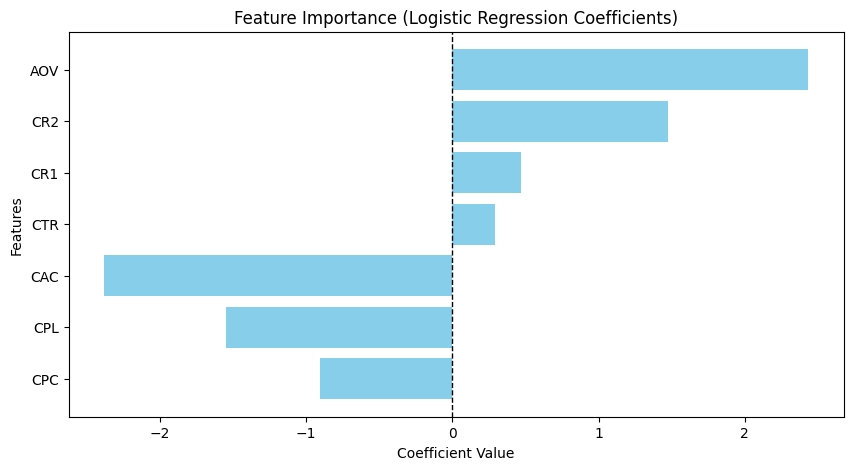

In [18]:
feature_importance = model.coef_[0]  

# Create a bar chart for visualization
plt.figure(figsize=(10, 5))
plt.barh(features, feature_importance, color="skyblue")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)
plt.show()

Although predictive modeling is not the goal of this project, we apply Logistic Regression to check whether the dataset captures meaningful insights. Feature importance analysis helps verify if key metrics like CPC, CPL, and CAC negatively influence campaign success, while engagement-related metrics contribute positively. This approach ensures our dataset aligns with real-world marketing behavior before proceeding to segmentation with clustering.

# Clustering
Applied K-means clustering to segment the data, determining which clustersfit optimally.

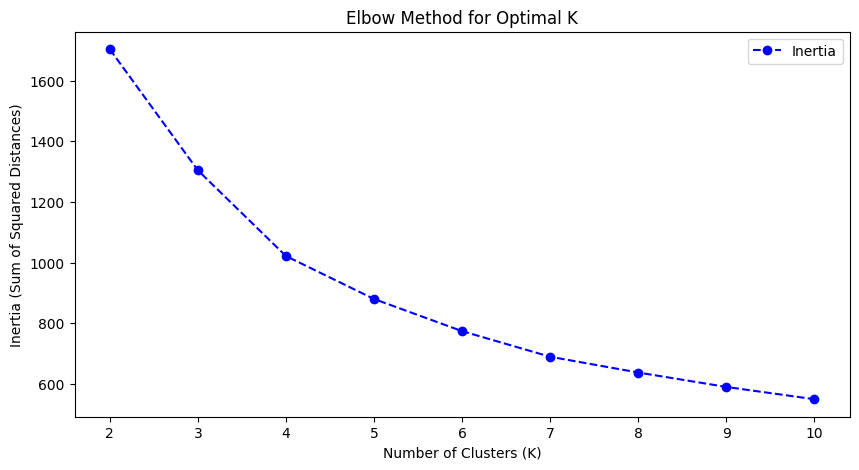

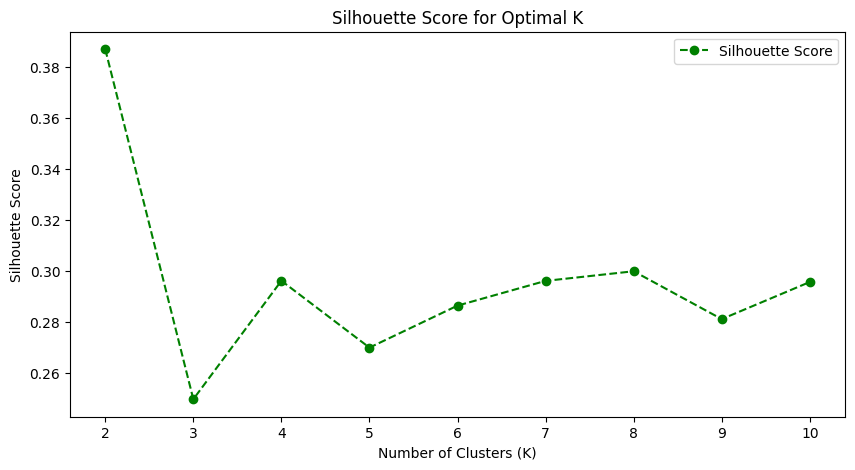

In [19]:
# Selecting relevant numerical features for clustering
features = ["CPC", "CPL", "CAC", "CTR", "CR1", "CR2", "AOV"]
X = df_results[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Finding the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # Testing clusters from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b', label='Inertia')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

# Plotting Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='g', label='Silhouette Score')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.legend()
plt.show()


Choosing the Optimal Number of Clusters (K) :
1. Understanding the Clustering Results -
We used the **Elbow Method** and **Silhouette Score** to determine the optimal number of clusters (K) for our marketing campaign data. Here’s what we observed:

- **Elbow Method**: The inertia (within-cluster variance) **gradually declines** from **1700 (K=2) to <600 (K=10)**. There is no sharp elbow, meaning multiple values of K could be reasonable. 
- **Silhouette Scores**: 
  - **Highest at K=2 (0.38)** → Suggests two broad, well-separated groups.  
  - **Lowest at K=3 (0.26)** → Indicates possible overlap between segments.  
  - **Relatively stable between K=4 to K=10 (0.28 - 0.31)**.  
  - **K=8 has the highest silhouette score (0.31) among the higher clusters**.  

2. Why We Chose K=4?
After analyzing the trade-offs, we selected **K=4** as the optimal number of clusters because:
- It provides **more actionable insights** than K=2 while avoiding over-segmentation like K=10.
- It aligns well with a **real-world marketing strategy**, where campaigns can be grouped into four distinct performance categories:
  1. 💰 **High-spending, high-return campaigns** (Profitable and scalable)
  2. 📉 **High-spending, low-return campaigns** (Needs optimization)
  3. 📊 **Low-spending, high-return campaigns** (Efficient campaigns with high ROI)
  4. ⚠️ **Low-spending, low-return campaigns** (Potentially ineffective campaigns)
- The silhouette score is stable, ensuring **clusters have meaningful separation without excessive overlap**.

3. Next Steps -
- We will visualize the clusters to understand their characteristics.
- The results will help in making **data-driven marketing decisions** to improve ROI.



# Scatter Plots 

Created three scatter plots for the 𝑘 = 4
k=4 clusters:

CR1 vs. CR2
CPC vs. ROMI
CPC vs. CAC

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_results["Cluster"] = kmeans.fit_predict(X_scaled)

centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df["Cluster"] = range(4)

In [21]:
fig = px.scatter(
    df_results, 
    x="CPC", 
    y="ROMI", 
    color=df_results["Cluster"].astype(str),
    hover_data=["campaign_name"],
    title="Clusters based on CPC vs ROMI"
)

fig.show()

In [22]:
fig = px.scatter(
    df_results, 
    x="CPC", 
    y="CAC", 
    color=df_results["Cluster"].astype(str),
    hover_data=["campaign_name"],
    title="Clusters based on CPC vs CAC",
    labels={"CPC": "Cost per Click", "CAC": "Customer Acquisition Cost"},
    category_orders={"Cluster": ["0", "1", "2", "3"]}
)

fig.show()

In [23]:
fig = px.scatter(
    df_results, 
    x="CR1", 
    y="CR2", 
    color=df_results["Cluster"].astype(str),
    hover_data=["campaign_name"],
    title="Clusters based on CR1 vs CR2",
    labels={"CR1": "Initial Conversion Rate", "CR2": "Final Conversion Rate"},
    category_orders={"Cluster": ["0", "1", "2", "3"]}  
) 

fig.show()

# Conclusion
This project provides valuable insights into marketing effectiveness, allowing for the identification of successful campaigns and opportunities for optimization. The calculated metrics and visualizations serve as actionable data for decision-making, enabling businesses to enhance their marketing strategies.

